In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2

%matplotlib inline

In [2]:
# Run this cell to connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data = np.load('/content/gdrive/MyDrive/GP_dataset/cropped_data_small.npy')

In [4]:
n = 125     # patients
tr, ts, val = int(n * 0.6), int(n * 0.2), int(n * 0.2)
# x_train = data[:tr*55]
# x_valid = data[tr*55: 55*(tr+val)]
x_test = data[55*(tr+val): n*55]

In [5]:
# y_train = np.load('/content/gdrive/MyDrive/GP_dataset/y_train.npy')
# y_valid = np.load('/content/gdrive/MyDrive/GP_dataset/y_valid.npy')
y_test = np.load('/content/gdrive/MyDrive/GP_dataset/y_test.npy')

In [6]:
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras import backend as K
# import keras_tuner as Kt

K.set_image_data_format('channels_last')

project_name = '2D-Dense-Unet'
img_rows = 160
img_cols = 192
img_depth = 1
# 224, 192, 160

def dice_metric(y_true, y_pred):
  intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis= -1))
  union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis= -1))
  return 2*intersection / union

def jaccard_coeff(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def build():
      dropout = 0.5

      inputs = Input((img_rows, img_cols, 1))
      conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
      conc11 = concatenate([inputs, conv11], axis=3)
      conc11 = BatchNormalization()(conc11)
      conv12 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc11)
      conc12 = concatenate([inputs, conv12], axis=3)
      conc12 = BatchNormalization()(conc12)
      pool1 = MaxPooling2D(pool_size=(2, 2))(conc12)
      pool1 = BatchNormalization()(pool1)
      # add dropout
      pool1 = Dropout(rate= dropout)(pool1)

      conv21 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
      conc21 = concatenate([pool1, conv21], axis=3)
      conc21 = BatchNormalization()(conc21)
      conv22 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc21)
      conc22 = concatenate([pool1, conv22], axis=3)
      conc22 = BatchNormalization()(conc22)
      pool2 = MaxPooling2D(pool_size=(2, 2))(conc22)
      pool2 = BatchNormalization()(pool2)
      pool2 = Dropout(rate= dropout)(pool2)

      conv31 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
      conc31 = concatenate([pool2, conv31], axis=3)
      conc31 = BatchNormalization()(conc31)
      conv32 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc31)
      conc32 = concatenate([pool2, conv32], axis=3)
      pool3 = MaxPooling2D(pool_size=(2, 2))(conc32)
      pool3 = BatchNormalization()(pool3)
      pool3 = Dropout(rate= dropout)(pool3)

      conv41 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
      conc41 = concatenate([pool3, conv41], axis=3)
      conc41 = BatchNormalization()(conc41)
      conv42 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc41)
      conc42 = concatenate([pool3, conv42], axis=3)
      pool4 = MaxPooling2D(pool_size=(2, 2))(conc42)
      pool4 = BatchNormalization()(pool4)
      pool4 = Dropout(rate= dropout)(pool4)

      conv51 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
      conc51 = concatenate([pool4, conv51], axis=3)
      conc51 = BatchNormalization()(conc51)
      conv52 = Conv2D(512, (3, 3), activation='relu', padding='same')(conc51)
      conc52 = concatenate([pool4, conv52], axis=3)
      conc52 = BatchNormalization()(conc52)
      conc52 = Dropout(rate= dropout)(conc52)

      up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conc52), conc42], axis=3)
      conv61 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
      conc61 = concatenate([up6, conv61], axis=3)
      conc61 = BatchNormalization()(conc61)
      conv62 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc61)
      conc62 = concatenate([up6, conv62], axis=3)
      conc62 = BatchNormalization()(conc62)
      # add dropout
      conc62 = Dropout(rate= dropout)(conc62)

      up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conc62), conv32], axis=3)
      conv71 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
      conc71 = concatenate([up7, conv71], axis=3)
      conc71 = BatchNormalization()(conc71)
      conv72 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc71)
      conc72 = concatenate([up7, conv72], axis=3)
      conc72 = BatchNormalization()(conc72)
      conc72 = Dropout(rate= dropout)(conc72)

      up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conc72), conv22], axis=3)
      conv81 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
      conc81 = concatenate([up8, conv81], axis=3)
      conc81 = BatchNormalization()(conc81)
      conv82 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc81)
      conc82 = concatenate([up8, conv82], axis=3)
      conc82 = BatchNormalization()(conc82)
      conc82 = Dropout(rate= dropout)(conc82)

      up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conc82), conv12], axis=3)
      conv91 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
      conc91 = concatenate([up9, conv91], axis=3)
      conc91 = BatchNormalization()(conc91)
      conv92 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc91)
      conc92 = concatenate([up9, conv92], axis=3)
      conc92 = BatchNormalization()(conc92)


      conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conc92)

      model = tf.keras.Model(inputs=[inputs], outputs=[conv10])


      model.compile(optimizer=Adam(learning_rate= 0.001), loss='binary_crossentropy', metrics=['accuracy', dice_metric, jaccard_coeff])

      return model

In [7]:
model_path = '/content/gdrive/MyDrive/gp_models/1ch_firstModel_50epoch/model'
model = tf.keras.models.load_model(model_path, custom_objects = {"dice_metric": dice_metric, "jaccard_coeff": jaccard_coeff})

# Check its architecture
# model.summary()

In [8]:
predicted_masks = model.predict(x_test)

43/43 [==============================] - 27s 276ms/step


In [9]:
twoD_masks = np.reshape(predicted_masks, (1375, 160, 192))
twoD_y = np.reshape(y_test, (1375, 160, 192))

In [10]:
twoD_masks.min()    # the current range is 0 -> 1

1.6359323e-25

In [11]:
# threshold the image to binary -> to detect region properties must be binary
import cv2
masks_binary = np.asarray([cv2.threshold(img, 0.08, 1, cv2.THRESH_BINARY)[1] for img in twoD_masks])  # cv2.threshold give tuple (threshold, output img)
y_binary = np.asarray([cv2.threshold(img, 0.08, 1, cv2.THRESH_BINARY)[1] for img in twoD_y.astype(np.float32)])

In [12]:
# rescale to 0 -> 255
masks_binary = (masks_binary*255).astype(np.uint8)
y_binary = (y_binary*255).astype(np.uint8)

In [ ]:
# show masks and image
N = 819
fig, arr = plt.subplots(1, 1, figsize=(3, 3))
arr.imshow(post_img[N][:,:])
# arr.set_title('Image')

img = masks_binary[N]
cv2_imshow(img)

 the image must have the circle all in white other parts in black

Calculate eccentricity (deviation from a perfect circle), euler number (number of holes in images)

In [142]:
from skimage import morphology
post_img = [morphology.area_opening(img, 500, connectivity= 2) for img in masks_binary]    # 1 centimeter [cm] = 37.7952755905511 pixel (X). 5, 25, up to 100 differences in 30   400 -> 28

In [143]:
measure.regionprops(post_img[N])[0].area

1316

In [144]:
def condition (reg):     # sort from biggest area to lowest
  return -1 * reg.area

In [145]:
# get euler number and eccentricity of predicted masks
from skimage import measure

labelled_img = [measure.label(img) for img in post_img]
region_props = [measure.regionprops(np.squeeze(img)) for img in labelled_img]    # list of 1375: each ele is list of 1, website says use np.squeeze

eccentricities = []
euler_numbers = []

for region in region_props:
  region.sort(key= condition)
  if(len(region) > 0):    # if all area is suppressed --> region is empty list
    eccentricities.append(region[0].eccentricity)     # take region of largest area
    euler_numbers.append(region[0].euler_number)
    # if len(region) > 1:
    #   print(region[0].area, region[1].area)
# print(len(eccentricities))

In [146]:
eccentricities = np.array(eccentricities)
euler_numbers = np.array(euler_numbers)

In [147]:
# lens = np.array([len(img_regions) for img_regions in (region_props)])
# print(np.unique(lens))

# idx = []
# for i in range(len(region_props)):
#   if len(region_props[i]) != 1:
#     idx.append(i)
# print(len(idx))

In [148]:
# get euler number and eccentricity of y masks

labelled_img_y = [measure.label(img) for img in y_binary]
region_props_y = [measure.regionprops(np.squeeze(img)) for img in labelled_img_y]    # list of 1375: each ele is list of 1, website says use np.squeeze

eccentricities_y = []
euler_numbers_y = []

for region in region_props_y:
  region.sort(key= condition)
  if(len(region) > 0):    # if all area is suppressed --> region is empty list
    eccentricities_y.append(region[0].eccentricity)     # take region of largest area
    euler_numbers_y.append(region[0].euler_number)

eccentricities_y = np.array(eccentricities_y)
euler_numbers_y = np.array(euler_numbers_y)

In [149]:
print(eccentricities.min(), eccentricities.max())
print(np.unique(euler_numbers))

0.08460567288988648 0.8598867010195893
[-1  0  1]


In [150]:
print(eccentricities_y.min(), eccentricities_y.max())   # use 0.7159 as threshold for improper masks
print(np.unique(euler_numbers_y))

0.06542858100825143 0.7159156131071974
[0 1]


In [151]:
threshold = 0.7159
improper_ecc = np.where(eccentricities > threshold)   # tuple of array
improper_eu = np.where(euler_numbers != 0)
improper_eu_y = np.where(euler_numbers_y != 0)
improper_ecc_y = np.where(eccentricities_y > threshold)

print("percentage of improper euler number metriced images of all images: ", improper_eu[0].shape[0]/ twoD_y.shape[0])
print("number of improper euler: {}, number of improper eccentricities: {}".format(improper_eu[0].shape[0], improper_ecc[0].shape[0]))
print("number of improper euler in y_test: {}, number of improper eccentricities in y_test: {}".format(improper_eu_y[0].shape[0], improper_ecc_y[0].shape[0]))

percentage of improper euler number metriced images of all images:  0.01890909090909091
number of improper euler: 26, number of improper eccentricities: 12
number of improper euler in y_test: 1, number of improper eccentricities in y_test: 1


IndexError: ignored

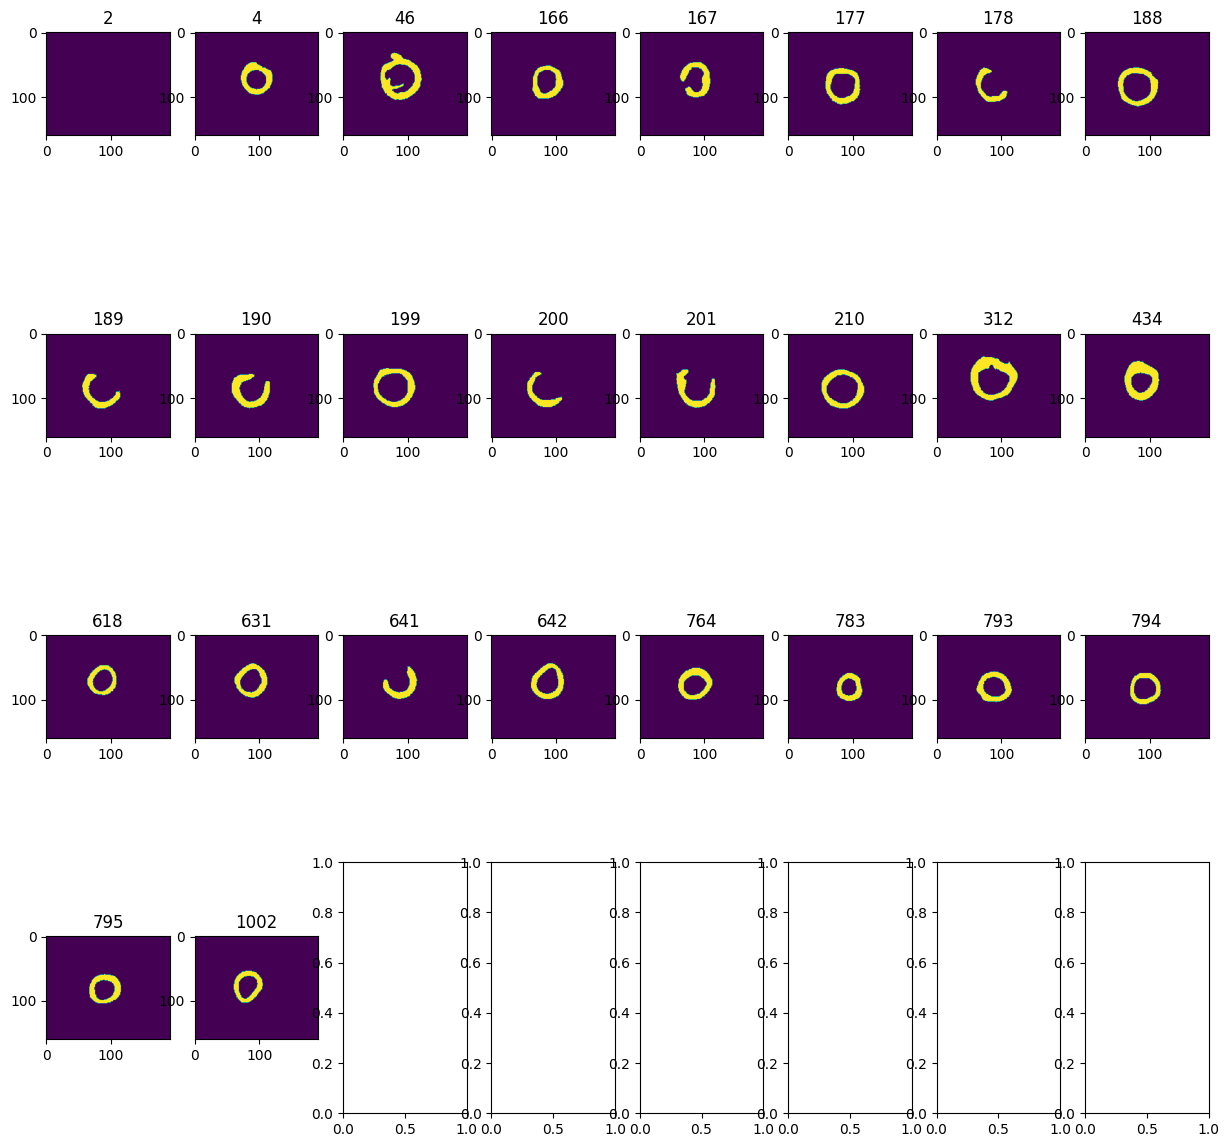

In [152]:
# show improper masks
N = 0
fig, arr = plt.subplots(4, 8, figsize=(15, 15))
for i in range(4):
  for j in range(8):
    arr[i][j].imshow(labelled_img[improper_eu[0][N]][:,:])
    arr[i][j].set_title(improper_eu[0][N])
    N += 1

In [ ]:
min_area = 3000
idx = 0
for n in range(len(region_props)):
  if(len(region_props[n]) > 0):     # 413,  idx = 497
    if min_area > region_props[n][0].area:
      min_area = min(min_area, region_props[n][0].area)
      idx = n
print(min_area, idx)